In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd My Drive
%cd Skripsi
%cd dataset

/gdrive/My Drive
/gdrive/My Drive/Skripsi
/gdrive/My Drive/Skripsi/dataset


In [ ]:
!unzip chestxrayfix.zip

Archive:  chestxrayfix.zip
   creating: chestxrayfix/
   creating: chestxrayfix/test/
   creating: chestxrayfix/test/KARDIOMEGALI/
  inflating: chestxrayfix/test/KARDIOMEGALI/01afcfaabc406f0fe1797cb7fa6616c6.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01c2b9fcb0384c84648ed76c736552a8.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01cbbeab94b4d2bfd5cd8a467fee46a7.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01d6446afde9fbf4332904bc331e9660.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01ee6e560f083255a630c41bba779405.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01f88c998eea22d21ee144bc3edfd261.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/01fec681f2d698497151a88d6c5205a1.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/02a4774868d677ef8ecff2168c0161c0.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/02acf0e7d0932f9c6a06fd4bbe1f5d90.png  
  inflating: chestxrayfix/test/KARDIOMEGALI/02cd1d17763c869ff3d4af5e28539456.png  
  inflating: chestxrayfix/test/KARDIOME

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [ ]:
labels = ['KARDIOMEGALI', 'NORMAL']
img_size = 128
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('chestxrayfix/train')
test = get_training_data('chestxrayfix/test')
val = get_training_data('chestxrayfix/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


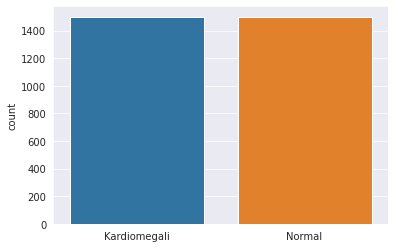

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Kardiomegali")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

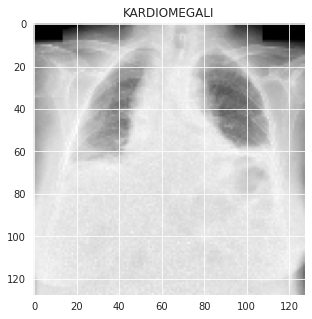

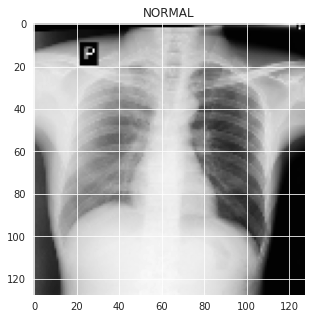

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [ ]:
#Percobaan ke-1
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
120/120 [==============================] - 37s 61ms/step - loss: 0.6919 - accuracy: 0.5163 - val_loss: 0.6813 - val_accuracy: 0.6000
Epoch 2/10
120/120 [==============================] - 7s 54ms/step - loss: 0.6754 - accuracy: 0.5737 - val_loss: 0.6755 - val_accuracy: 0.5600
Epoch 3/10
120/120 [==============================] - 7s 55ms/step - loss: 0.6188 - accuracy: 0.6540 - val_loss: 0.5925 - val_accuracy: 0.6900
Epoch 4/10
120/120 [==============================] - 7s 56ms/step - loss: 0.5489 - accuracy: 0.7157 - val_loss: 0.4847 - val_accuracy: 0.7600
Epoch 5/10
120/120 [==============================] - 7s 54ms/step - loss: 0.4659 - accuracy: 0.7870 - val_loss: 0.4574 - val_accuracy: 0.8025
Epoch 6/10
120/120 [==============================] - 6s 53ms/step - loss: 0.4416 - accuracy: 0.7917 - val_loss: 0.3783 - val_accuracy: 0.8250
Epoch 7/10
120/120 [==============================] - 6s 53ms/step - loss: 0.4186 - accuracy: 0.8093 - val_loss: 0.4366 - val_accuracy: 0.787

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 2s 16ms/step - loss: 0.3479 - accuracy: 0.8453
Loss of the model is -  34.792086482048035 %
94/94 [==============================] - 1s 14ms/step - loss: 0.3479 - accuracy: 0.8453
Accuracy of the model is -  84.53333377838135 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 1s 17ms/step - loss: 0.3474 - accuracy: 0.8580
Loss of the model is -  34.737035632133484 %
32/32 [==============================] - 0s 14ms/step - loss: 0.3474 - accuracy: 0.8580
Accuracy of the model is -  85.79999804496765 %


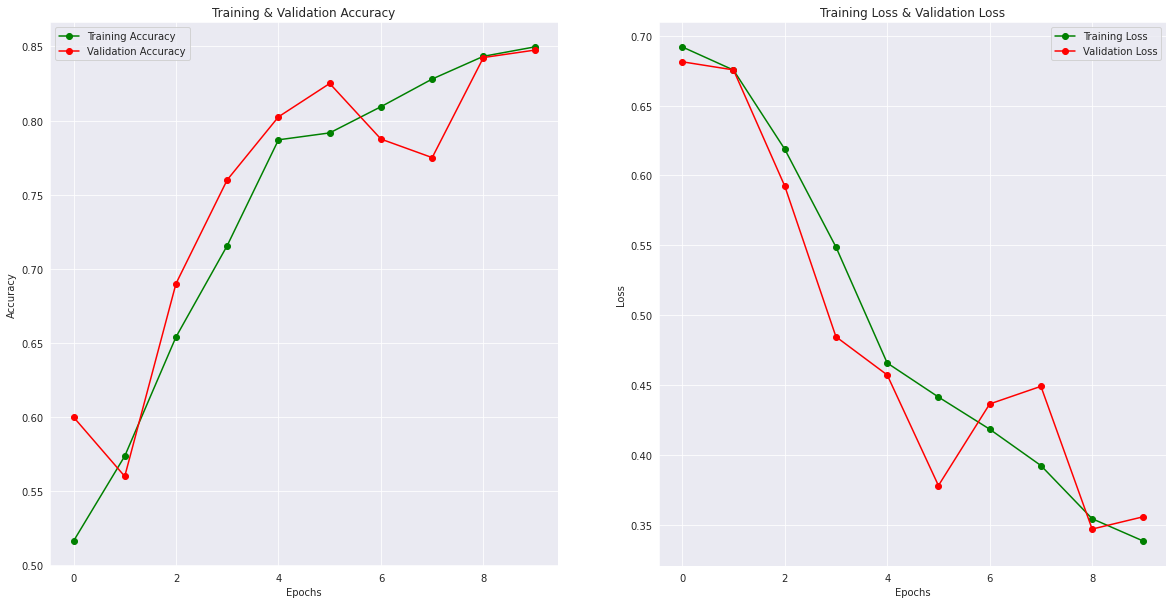

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
#Percobaan ke-2
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
120/120 [==============================] - 7s 59ms/step - loss: 0.3037 - accuracy: 0.8667 - val_loss: 0.2798 - val_accuracy: 0.8700
Epoch 2/20
120/120 [==============================] - 7s 57ms/step - loss: 0.2927 - accuracy: 0.8797 - val_loss: 0.2750 - val_accuracy: 0.8950
Epoch 3/20
120/120 [==============================] - 7s 58ms/step - loss: 0.2879 - accuracy: 0.8733 - val_loss: 0.2556 - val_accuracy: 0.8750
Epoch 4/20
120/120 [==============================] - 7s 58ms/step - loss: 0.2842 - accuracy: 0.8830 - val_loss: 0.3178 - val_accuracy: 0.8650
Epoch 5/20
120/120 [==============================] - 7s 58ms/step - loss: 0.2789 - accuracy: 0.8830 - val_loss: 0.2913 - val_accuracy: 0.8900
Epoch 6/20
120/120 [==============================] - 7s 57ms/step - loss: 0.2631 - accuracy: 0.8873 - val_loss: 0.2584 - val_accuracy: 0.8925
Epoch 7/20
120/120 [==============================] - 7s 60ms/step - loss: 0.2676 - accuracy: 0.8860 - val_loss: 0.2627 - val_accuracy: 0.8900

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 15ms/step - loss: 0.1465 - accuracy: 0.9513
Loss of the model is -  14.650379121303558 %
94/94 [==============================] - 1s 13ms/step - loss: 0.1465 - accuracy: 0.9513
Accuracy of the model is -  95.13333439826965 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 1s 16ms/step - loss: 0.1537 - accuracy: 0.9400
Loss of the model is -  15.367613732814789 %
32/32 [==============================] - 0s 14ms/step - loss: 0.1537 - accuracy: 0.9400
Accuracy of the model is -  93.99999976158142 %


In [ ]:
#Percobaan ke-3
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val))

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0862 - accuracy: 0.9653
Loss of the model is -  8.619309216737747 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0862 - accuracy: 0.9653
Accuracy of the model is -  96.5333342552185 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 13ms/step - loss: 0.1345 - accuracy: 0.9470
Loss of the model is -  13.451668620109558 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1345 - accuracy: 0.9470
Accuracy of the model is -  94.70000267028809 %


In [ ]:
#Percobaan ke-4
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 40 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/40
120/120 [==============================] - 7s 56ms/step - loss: 0.1313 - accuracy: 0.9427 - val_loss: 0.1674 - val_accuracy: 0.9300
Epoch 2/40
120/120 [==============================] - 7s 55ms/step - loss: 0.1362 - accuracy: 0.9450 - val_loss: 0.1712 - val_accuracy: 0.9250
Epoch 3/40
120/120 [==============================] - 7s 55ms/step - loss: 0.1249 - accuracy: 0.9503 - val_loss: 0.1687 - val_accuracy: 0.9375
Epoch 4/40
120/120 [==============================] - 7s 54ms/step - loss: 0.1436 - accuracy: 0.9473 - val_loss: 0.2569 - val_accuracy: 0.9250
Epoch 5/40
120/120 [==============================] - 7s 55ms/step - loss: 0.1250 - accuracy: 0.9500 - val_loss: 0.1791 - val_accuracy: 0.9325
Epoch 6/40
120/120 [==============================] - 7s 55ms/step - loss: 0.1300 - accuracy: 0.9447 - val_loss: 0.1907 - val_accuracy: 0.9250
Epoch 7/40
120/120 [==============================] - 7s 56ms/step - loss: 0.1302 - accuracy: 0.9507 - val_loss: 0.1581 - val_accuracy: 0.9400

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0581 - accuracy: 0.9787
Loss of the model is -  5.814263224601746 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0581 - accuracy: 0.9787
Accuracy of the model is -  97.86666631698608 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 13ms/step - loss: 0.1520 - accuracy: 0.9600
Loss of the model is -  15.202444791793823 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1520 - accuracy: 0.9600
Accuracy of the model is -  95.99999785423279 %


In [ ]:
#Percobaan ke-5
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 50 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/50
120/120 [==============================] - 7s 56ms/step - loss: 0.0898 - accuracy: 0.9643 - val_loss: 0.1375 - val_accuracy: 0.9425
Epoch 2/50
120/120 [==============================] - 7s 55ms/step - loss: 0.1107 - accuracy: 0.9540 - val_loss: 0.1319 - val_accuracy: 0.9575
Epoch 3/50
120/120 [==============================] - 7s 56ms/step - loss: 0.0920 - accuracy: 0.9637 - val_loss: 0.1629 - val_accuracy: 0.9375
Epoch 4/50
120/120 [==============================] - 7s 56ms/step - loss: 0.0961 - accuracy: 0.9663 - val_loss: 0.1502 - val_accuracy: 0.9525
Epoch 5/50
120/120 [==============================] - 7s 54ms/step - loss: 0.0896 - accuracy: 0.9623 - val_loss: 0.1402 - val_accuracy: 0.9500
Epoch 6/50
120/120 [==============================] - 6s 54ms/step - loss: 0.0833 - accuracy: 0.9673 - val_loss: 0.1238 - val_accuracy: 0.9550
Epoch 7/50
120/120 [==============================] - 7s 56ms/step - loss: 0.0987 - accuracy: 0.9593 - val_loss: 0.1902 - val_accuracy: 0.9275

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0330 - accuracy: 0.9900
Loss of the model is -  3.2983023673295975 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0330 - accuracy: 0.9900
Accuracy of the model is -  99.00000095367432 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 13ms/step - loss: 0.1490 - accuracy: 0.9570
Loss of the model is -  14.900150895118713 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1490 - accuracy: 0.9570
Accuracy of the model is -  95.70000171661377 %


In [ ]:
#Percobaan ke-6
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
60/60 [==============================] - 7s 102ms/step - loss: 0.0573 - accuracy: 0.9800 - val_loss: 0.1935 - val_accuracy: 0.9500
Epoch 2/10
60/60 [==============================] - 6s 99ms/step - loss: 0.0546 - accuracy: 0.9783 - val_loss: 0.1819 - val_accuracy: 0.9325
Epoch 3/10
60/60 [==============================] - 6s 98ms/step - loss: 0.0497 - accuracy: 0.9803 - val_loss: 0.2182 - val_accuracy: 0.9525
Epoch 4/10
60/60 [==============================] - 6s 99ms/step - loss: 0.0455 - accuracy: 0.9853 - val_loss: 0.1723 - val_accuracy: 0.9525
Epoch 5/10
60/60 [==============================] - 6s 102ms/step - loss: 0.0511 - accuracy: 0.9810 - val_loss: 0.1821 - val_accuracy: 0.9575
Epoch 6/10
60/60 [==============================] - 6s 105ms/step - loss: 0.0449 - accuracy: 0.9823 - val_loss: 0.1637 - val_accuracy: 0.9475
Epoch 7/10
60/60 [==============================] - 7s 109ms/step - loss: 0.0458 - accuracy: 0.9823 - val_loss: 0.1798 - val_accuracy: 0.9425
Epoch 8/1

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0259 - accuracy: 0.9913
Loss of the model is -  2.593228407204151 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0259 - accuracy: 0.9913
Accuracy of the model is -  99.13333058357239 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 14ms/step - loss: 0.1779 - accuracy: 0.9590
Loss of the model is -  17.78527796268463 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1779 - accuracy: 0.9590
Accuracy of the model is -  95.89999914169312 %


In [ ]:
#Percobaan ke-7
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
60/60 [==============================] - 6s 98ms/step - loss: 0.0558 - accuracy: 0.9800 - val_loss: 0.2032 - val_accuracy: 0.9400
Epoch 2/20
60/60 [==============================] - 6s 99ms/step - loss: 0.0586 - accuracy: 0.9773 - val_loss: 0.1634 - val_accuracy: 0.9375
Epoch 3/20
60/60 [==============================] - 6s 97ms/step - loss: 0.0414 - accuracy: 0.9847 - val_loss: 0.2610 - val_accuracy: 0.9475
Epoch 4/20
60/60 [==============================] - 6s 97ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.1736 - val_accuracy: 0.9450
Epoch 5/20
60/60 [==============================] - 6s 98ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.2044 - val_accuracy: 0.9425
Epoch 6/20
60/60 [==============================] - 6s 101ms/step - loss: 0.0722 - accuracy: 0.9767 - val_loss: 0.1410 - val_accuracy: 0.9675
Epoch 7/20
60/60 [==============================] - 6s 102ms/step - loss: 0.0454 - accuracy: 0.9830 - val_loss: 0.1693 - val_accuracy: 0.9650
Epoch 8/20


In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0165 - accuracy: 0.9943
Loss of the model is -  1.646101102232933 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0165 - accuracy: 0.9943
Accuracy of the model is -  99.43333268165588 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 15ms/step - loss: 0.1356 - accuracy: 0.9660
Loss of the model is -  13.563638925552368 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1356 - accuracy: 0.9660
Accuracy of the model is -  96.60000205039978 %


In [ ]:
#Percobaan ke-8
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/30
60/60 [==============================] - 6s 102ms/step - loss: 0.0563 - accuracy: 0.9760 - val_loss: 0.1075 - val_accuracy: 0.9600
Epoch 2/30
60/60 [==============================] - 6s 99ms/step - loss: 0.0442 - accuracy: 0.9823 - val_loss: 0.2099 - val_accuracy: 0.9525
Epoch 3/30
60/60 [==============================] - 6s 100ms/step - loss: 0.0495 - accuracy: 0.9813 - val_loss: 0.1472 - val_accuracy: 0.9550
Epoch 4/30
60/60 [==============================] - 6s 103ms/step - loss: 0.0647 - accuracy: 0.9747 - val_loss: 0.1188 - val_accuracy: 0.9700
Epoch 5/30
60/60 [==============================] - 6s 105ms/step - loss: 0.0434 - accuracy: 0.9813 - val_loss: 0.2134 - val_accuracy: 0.9325
Epoch 6/30
60/60 [==============================] - 6s 108ms/step - loss: 0.0535 - accuracy: 0.9790 - val_loss: 0.1808 - val_accuracy: 0.9500
Epoch 7/30
60/60 [==============================] - 6s 106ms/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.2492 - val_accuracy: 0.9375
Epoch 8

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 14ms/step - loss: 0.0199 - accuracy: 0.9937
Loss of the model is -  1.9860386848449707 %
94/94 [==============================] - 1s 14ms/step - loss: 0.0199 - accuracy: 0.9937
Accuracy of the model is -  99.36666488647461 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 15ms/step - loss: 0.1835 - accuracy: 0.9660
Loss of the model is -  18.345703184604645 %
32/32 [==============================] - 0s 14ms/step - loss: 0.1835 - accuracy: 0.9660
Accuracy of the model is -  96.60000205039978 %


In [ ]:
#Percobaan ke-9
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 40 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/40
60/60 [==============================] - 6s 104ms/step - loss: 0.0439 - accuracy: 0.9830 - val_loss: 0.2381 - val_accuracy: 0.9500
Epoch 2/40
60/60 [==============================] - 6s 105ms/step - loss: 0.0412 - accuracy: 0.9860 - val_loss: 0.1993 - val_accuracy: 0.9475
Epoch 3/40
60/60 [==============================] - 6s 104ms/step - loss: 0.0419 - accuracy: 0.9843 - val_loss: 0.1631 - val_accuracy: 0.9575
Epoch 4/40
60/60 [==============================] - 6s 104ms/step - loss: 0.0388 - accuracy: 0.9837 - val_loss: 0.1941 - val_accuracy: 0.9575
Epoch 5/40
60/60 [==============================] - 6s 104ms/step - loss: 0.0541 - accuracy: 0.9823 - val_loss: 0.1898 - val_accuracy: 0.9525
Epoch 6/40
60/60 [==============================] - 6s 105ms/step - loss: 0.0444 - accuracy: 0.9853 - val_loss: 0.1693 - val_accuracy: 0.9475
Epoch 7/40
60/60 [==============================] - 6s 104ms/step - loss: 0.0423 - accuracy: 0.9840 - val_loss: 0.1760 - val_accuracy: 0.9600
Epoch 

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 15ms/step - loss: 0.0148 - accuracy: 0.9950
Loss of the model is -  1.48484967648983 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0148 - accuracy: 0.9950
Accuracy of the model is -  99.50000047683716 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 14ms/step - loss: 0.1883 - accuracy: 0.9630
Loss of the model is -  18.830937147140503 %
32/32 [==============================] - 0s 13ms/step - loss: 0.1883 - accuracy: 0.9630
Accuracy of the model is -  96.29999995231628 %


In [ ]:
#Percobaan ke-10
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 50 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.2389 - val_accuracy: 0.9475
Epoch 2/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0453 - accuracy: 0.9810 - val_loss: 0.2015 - val_accuracy: 0.9500
Epoch 3/50
60/60 [==============================] - 6s 97ms/step - loss: 0.0445 - accuracy: 0.9823 - val_loss: 0.1911 - val_accuracy: 0.9500
Epoch 4/50
60/60 [==============================] - 6s 97ms/step - loss: 0.0430 - accuracy: 0.9823 - val_loss: 0.1447 - val_accuracy: 0.9450
Epoch 5/50
60/60 [==============================] - 6s 98ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.2229 - val_accuracy: 0.9500
Epoch 6/50
60/60 [==============================] - 6s 99ms/step - loss: 0.0406 - accuracy: 0.9857 - val_loss: 0.2412 - val_accuracy: 0.9475
Epoch 7/50
60/60 [==============================] - 6s 104ms/step - loss: 0.0359 - accuracy: 0.9867 - val_loss: 0.1157 - val_accuracy: 0.9550
Epoch 8/50
6

In [ ]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

94/94 [==============================] - 1s 15ms/step - loss: 0.0193 - accuracy: 0.9930
Loss of the model is -  1.9271792843937874 %
94/94 [==============================] - 1s 13ms/step - loss: 0.0193 - accuracy: 0.9930
Accuracy of the model is -  99.29999709129333 %


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 1s 16ms/step - loss: 0.2297 - accuracy: 0.9570
Loss of the model is -  22.96799123287201 %
32/32 [==============================] - 0s 14ms/step - loss: 0.2297 - accuracy: 0.9570
Accuracy of the model is -  95.70000171661377 %


In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:100]


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Kardiomegali','Normal']))

              precision    recall  f1-score   support

Kardiomegali       0.98      0.94      0.96       500
      Normal       0.94      0.98      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[468,  32],
       [ 11, 489]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

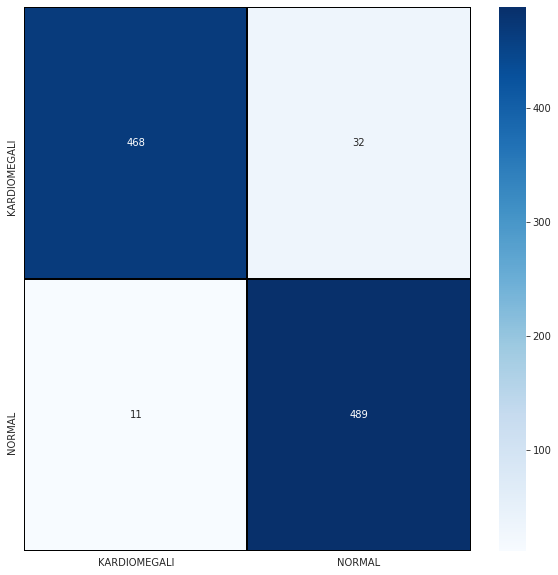

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

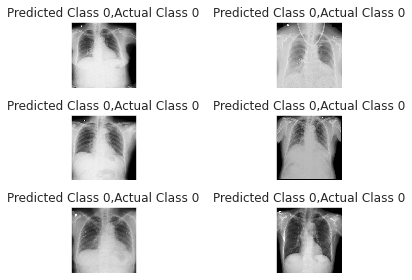

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1



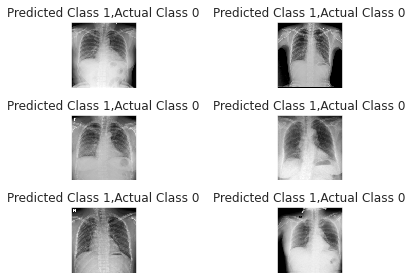

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

